## Especificação:

Nesta atividade você vai construir uma aplicação escolhendo uma das técnicas vistas no último módulo da disciplina. A atividade é individual. As possíveis aplicações são as seguintes:

    Classificação de notícias vs sátiras.
    Agrupamento de notícias.
    Análise de Sentimentos no Twitter.
    Sistemas de recomendação (filmes ou notícias).
    Detecção de viés em notícias.

As explicações do que fazer exatamente em cada uma foram dadas na aula do dia 16/07. 

O que entregar?

    Código documentado, de preferência link no github do notebook jupyter;
    Exemplos de funcionamento.

Critérios de correção

    Como de praxe, corretude e legibilidade.

Dicas

    Não falte as aulas de acompanhamento.
    Não deixe para última hora.
    Se faltou a aula do dia 16/07, procure com urgência o professor, monitores ou colegas trabalhando no tema de sua escolha para explicar o que deve ser feito.

Entregas com atraso

    Será descontado 10 pontos por dia de atraso


## Técnica escolhida: Agrupamento de notícias.

Breve descrição:
    
    No caso de notícias:

    Você vai usar os dados de notícias já utilizado em outras atividades;
    O algoritmo é basicamente o KNN;
    Passe uma notícia como consulta e retorne as top-5 mais similares (em termos de coseno ou produto escalar);
    A entrega é a mesma que filmes com exceção do RMSE.



## Código - Início

#### Organização dos imports

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import nltk
import re
from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from unicodedata import normalize
from nltk.tokenize import word_tokenize
import numpy as np
import random
from collections import Counter
from nltk.corpus import stopwords

#### Downloads do nltk necessarios para dados mais relevantes

In [3]:
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arthur.r.oliveira\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arthur.r.oliveira\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!


True

#### Recuperando documento e seu conteudo

In [4]:
news = pd.read_csv("./estadao_noticias_eleicao.csv", encoding="utf-8")
content = news.titulo + " " + news.subTitulo + " " + news.conteudo
content = content.fillna("")

#### Passo 1: Transformando em vetor
##### neste passo, estamos considerando ate o indice 1000 do documento, dado que o documento é muito grande e prejudica a performance

In [5]:
count_vect = TfidfVectorizer()
X_train_counts = count_vect.fit_transform(content[:1000])
X_train_counts.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Verificando os centroides

1 568.9466880895357
2 518.573809049568
3 510.697506676804
4 505.4077776601883
5 508.5125223562429
6 502.00260909289585
7 500.19182855554135
8 505.1626701419734
9 501.6603037301754
10 501.91628790303514


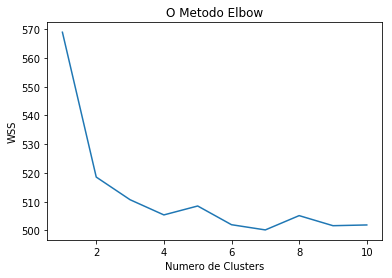

In [6]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(X_train_counts.toarray())
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)  
plt.plot(range(1, 11), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares
plt.show()

#### Iniciando o k-means e agrupar os dados a partir melhor K encontrado no metodo Elbow

In [7]:
#Kmeans = 3
kmeans = KMeans(n_clusters = 3, init = 'random', max_iter=1000, n_init=10)
kmeans.fit(X_train_counts.toarray())

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=1000,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

#### Elaborando os graficos - Centroide

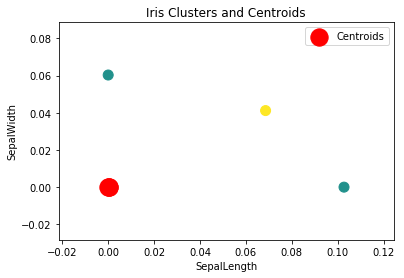

In [8]:
plt.scatter(X_train_counts.toarray()[:, 0], X_train_counts.toarray()[:,1], s = 100, c = kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'red',label = 'Centroids')
plt.title('Iris Clusters and Centroids')
plt.xlabel('SepalLength')
plt.ylabel('SepalWidth')
plt.legend()
 
plt.show()

#### Modificando o documento para desconsiderar stopwords

In [9]:
def build(data):
    data["noticia"] = content
    formatted_docs = []
    stop_words = set(stopwords.words('portuguese'))
    stop_words.add('e')
    stop_words.add('é')
    stop_words.add('ser')
    stop_words.add('ele')
    stop_words.add('vai')
    stop_words.add('na')
    stop_words.add('da')
    stop_words.add('que')
    stop_words.add('em')
    stop_words.add('se')
    stop_words.add('de')
    
    
    for index, doc in data.iterrows():
        doc.noticia = doc.noticia.lower()
        word_tokens = word_tokenize(doc.noticia)
        filtered_sentence = [w for w in word_tokens if not w in stop_words]
        news = ' '.join(filtered_sentence)
        formatted_docs.append(clear_text(news))

    return formatted_docs

def clear_text(text):
    pattern = re.compile('[^a-zA-Z0-9]')
    text = normalize('NFKD', text).encode('ASCII', 'ignore').decode('ASCII')
    return pattern.sub(' ', text)

modified_news = build(news)

#### Gerando word cloud para os k (3) grupos

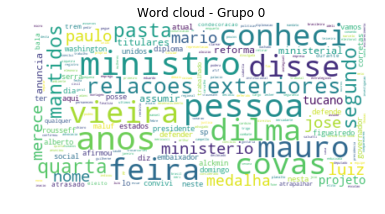

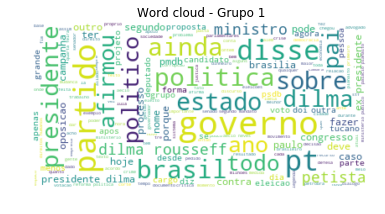

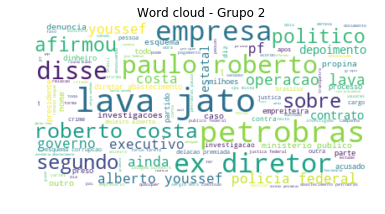

In [13]:
groups_dic = {}
groups_term_freq = {}

labels = kmeans.labels_

for i in range(1000):
    groups_dic.setdefault(labels[i], []).append(modified_news[i])
    
for group in sorted(groups_dic.keys()):
    groups_dic[group] = ' '.join(groups_dic[group])
    words = [word.lower() for word in nltk.word_tokenize(groups_dic[group])]
    freq_words = Counter(words)
    groups_term_freq[group] = freq_words.most_common()
    wordcloud = WordCloud(background_color='white', max_font_size=40).generate(groups_dic[group])
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title('Word cloud - Grupo ' + str(group))
    plt.axis("off")

#### Elaborando grafico de barras com as palavras mais relevantes

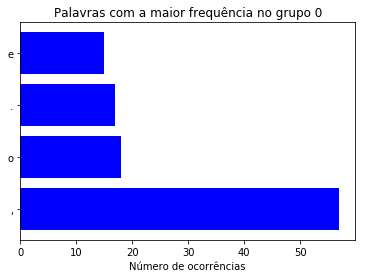

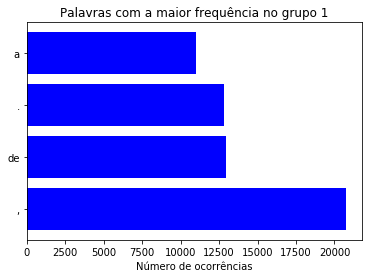

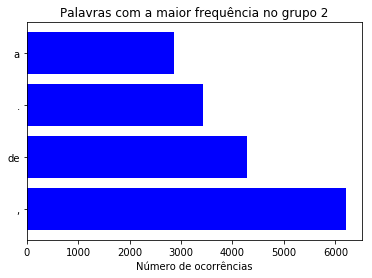

In [12]:
import plotly.plotly as py

for group in sorted(groups_term_freq.keys()):
    s = groups_term_freq[group][:4]
    y = []
    x = []
    for i in range(len(s)):
        x.append(s[i][0])
        y.append(s[i][1])

    plt.figure()
    plt.barh(x, y, color="blue")
    plt.xlabel("Número de ocorrências")
    plt.title("Palavras com a maior frequência no grupo " + str(group))